# Comunicados de Política Monetaria
## Parte 1.

En este notebook crearemos un pandas DataFrame con las decisiones de política monetaria de Banxico y haremos un análisis de la información recabada.

In [427]:
from requests_html import HTMLSession
from collections import defaultdict
from unidecode import unidecode
from datetime import datetime
import re
import os
import locale
import pandas as pd
import matplotlib.pyplot as plt

In [428]:
locale.setlocale(locale.LC_TIME, "es_ES.UTF-8")
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = (12, 4)

La información de decisción de política monetaria se encuentra en la siguiente url.

In [429]:
url = ("https://www.banxico.org.mx/publicaciones-y-prensa/"
      "anuncios-de-las-decisiones-de-politica-monetaria/"
      "anuncios-politica-monetaria-t.html")

* Entra a `url` y analiza la página.

In [430]:
print(url)

https://www.banxico.org.mx/publicaciones-y-prensa/anuncios-de-las-decisiones-de-politica-monetaria/anuncios-politica-monetaria-t.html


In [479]:
class Article:
    
    def __init__(self, date, text, url):
        self.date = date
        self.text = text
        self.url = url
        
    def to_dict(self):
        return {
            'date': self.date,
            'text': self.text,
            'url': self.url
        }
        
    def __str__(self):
        return "Fecha: {}\nUrl:  {}\nText: {}\n".format(self.date, self.url, self.text)
    
class Crawler():
    
    def __init__(self, r):
        self.r = r
    
    def get_articles(self):
        divpage = self.r.html.find("table[class='table table-striped bmtableview']", first=True)
        if divpage!=None:
            articles = []
            for arti in divpage.find("tbody", first=True).find("tr"):
                articles.append(get_article(arti))
            return articles
        else:
            print("No se encontró tabla con registros")
        return None
    
    def get_df(self, articles):
        df = pd.DataFrame.from_records([item.to_dict() for item in articles])
        df['date'] = pd.to_datetime(df["date"])
        df["category"] = df["text"].str.extract("(mantiene|incrementa|disminuye)", expand=False).str.strip()
        #print("Tipo de datos: {}".format(df.dtypes))
        return df
        
    def get_article(self, arti, fmt="%d/%m/%y"):
        date = arti.find("td[class='bmdateview']", first=True).text.strip()
        text = arti.find("td[class='bmtextview']", first=True).text.replace("Texto completo", "").strip()
        url, *_ = arti.find("a", first=True).absolute_links
        #date = datetime.strptime(date, fmt)
        article = Article(date, text, url)
        #print(article.__str__())
        return article

In [480]:
with HTMLSession() as sess:
    r = sess.get(url)
    r.encoding = 'utf-8'
    
crawler = Crawler(r)
articles = crawler.get_articles()
df = crawler.get_df(articles)

* Como podemos observar, la url objetivo contiene
    * las fechas de decisiones de política monetaria,
    * el resumen de las decisiones de política monetaria y
    * una url que nos dirige a un pdf con el texto completo del Anuncio de Política Monetaria.
    
<h3 style="color:crimson">Ejercicio</h3>

1. Por medio de `requests_html`, extrae los tres puntos antes mencionados y guárdalos dentro de un DataFrame con columnas `"date"`, `"text"` y `"url"`;
2. Con el dataframe seleccionado, filtra todos comunicados anteriores al 15 de febrero de 2008, i.e., queremos todos los comunicados a partir del 15 de Febrero de 2008;
3. Guarda tu DataFrame dentro de un archivo `.pkl` con nombre `comunicados-banxico.pkl`: **hint:** Revisa el uso del método `to_pickle`.

In [481]:
df[["date", "text", "url"]].head()

,date,text,url
0,2019-11-14,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...
1,2019-09-26,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...
2,2019-08-15,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...
3,2019-06-27,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...
4,2019-05-16,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...


<h3 style="color:crimson">Ejercicio</h3>

Por medio del método `str.extract` para un pandas Series, crea una nueva columna `"category"` que extraiga del texto si la tasa se 
1. `"mantiene"`
2. `"incrementa"`
3. `"disminuye"`

In [482]:
df.head()

,date,text,url,category
0,2019-11-14,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,disminuye
1,2019-09-26,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,disminuye
2,2019-08-15,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,disminuye
3,2019-06-27,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,mantiene
4,2019-05-16,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,mantiene


<h3 style="color:crimson">Ejercicio</h3>

Cuenta las veces en las que la tasa se mantuvo, se incrementó o se disminuyó.

In [483]:
print(df.groupby("category").count().iloc[:,0])

category
disminuye      14
incrementa     18
mantiene      122
Name: date, dtype: int64


<h3 style="color:crimson">Ejercicio</h3>

Reproduce la siguiente figura sobre los comunicados de prensa de Banxico:
1. La gráfica de la izquierda representa una serie de tiempo sobre los comunicados de banxico. Si `y=1`, la tasa de referencia se incrementó; si `y=0`, la tasa se mantuvo; finalmente, si `y=-1`, la tasa disminuyó.
2. La gráfica de la derecha es una gráfica de barras del ejercicio anterior

<h3 style="color:crimson">Ejercicio</h3>

Agrupa por año y cuenta el número de comunicados en un año para cada categoría.

In [496]:
temp_df = df.groupby([df['date'].map(lambda x: x.year), "category"]).count()
temp_df = temp_df.drop(["date", "url"], axis=1)
temp_df.rename(columns={"text":"total"}, inplace=True)
temp_df.reset_index()
temp_df.set_index("date")

KeyError: 'date'

<h3 style="color:crimson">Ejercicio</h3>

Con el resultado anterior, replica la siguiente gráfica

In [491]:
pivot_df = temp_df.pivot(index='date', columns='category', values='total')
pivot_df

KeyError: 'date'

/Users/sergio.delacruz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.


([array([0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.04195804, 0.        ]),
  array([0.        , 0.        , 0.        , 0.        , 0.04195804,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.04195804, 0.        ]),
  array([0.        , 0.        , 0.        , 0.        , 0.04195804,
         0.        , 0.        , 0.        , 0.04195804, 0.        ,
         0.04195804, 0.        ]),
  array([0.        , 0.        , 0.        , 0.        , 0.04195804,
         0.        , 0.        , 0.        , 0.04195804, 0.        ,
         0.04195804, 0.04195804]),
  array([0.        , 0.        , 0.        , 0.        , 0.04195804,
         0.        , 0.        , 0.        , 0.04195804, 0.        ,
         0.04195804, 0.08391608]),
  array([0.        , 0.        , 0.04195804, 0.        , 0.04195804,
         0.        , 0.        , 0.        , 0.04195804, 0.       

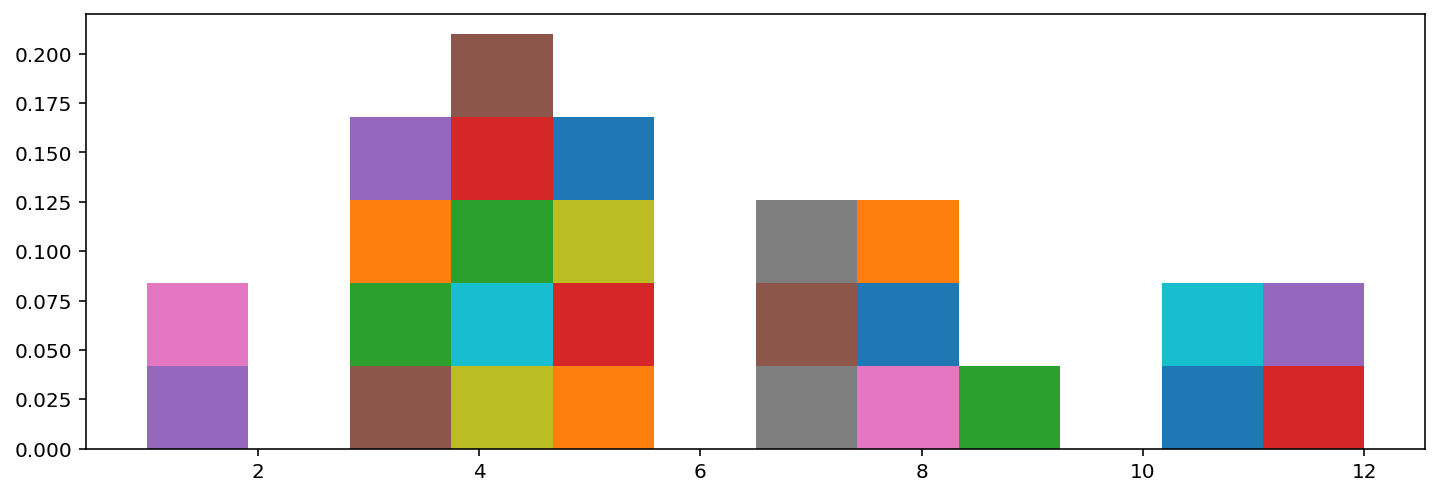

In [464]:
plt.hist(temp_df, bins = int(180/15), stacked=True,normed=True)

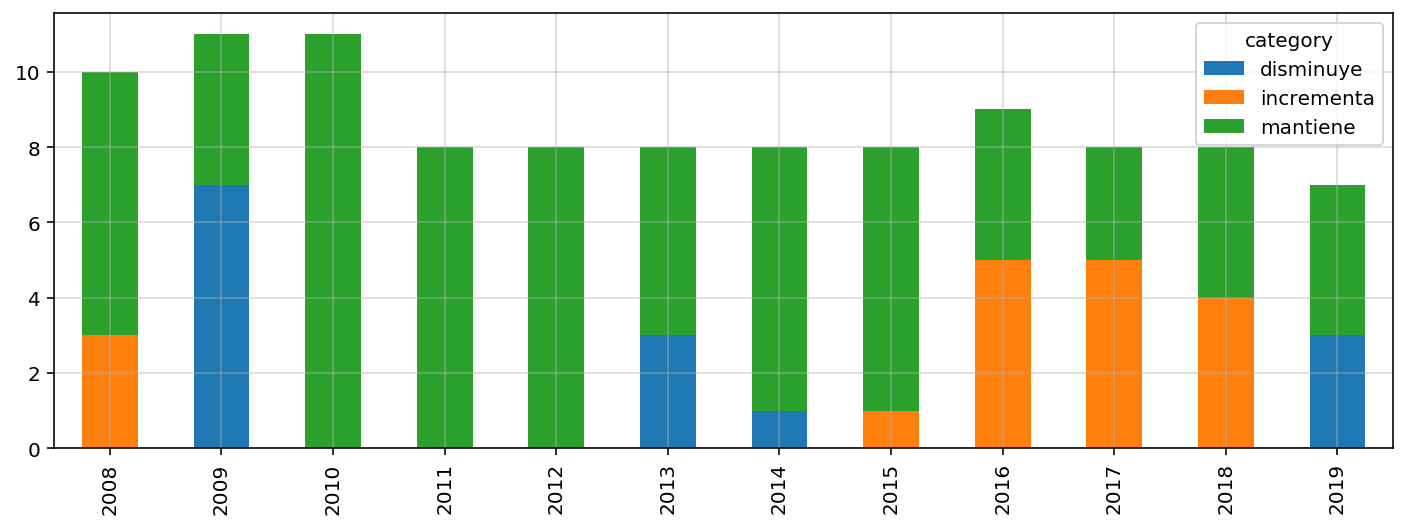